In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import datetime
import copy
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
import torch.nn.functional as F
from models.Buffer import Buffer
from models.DeepGenerator import GeneratorPolicy
from models.Discriminator import Discriminator
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *

In [2]:
# Training Folder
#path = r"..\data\pretuning"
#timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
#folder_name = f"Pretuning - {timestamp}"

path = r"..\models\trained_policies"

#save_dir = os.path.join(path, folder_name)
os.makedirs(path, exist_ok=True)

data_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\33'
couzin_path = rf"..\data\processed\couzin_interactions"
hl_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\flagged\hl_tensors'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = GeneratorPolicy(features=4).to(device)
pred_policy.set_parameters(init=True)

prey_policy = GeneratorPolicy(features=4).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device=device)

In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(couzin_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
# 70 ist hier zu wenig. Mehr auf hand-labeled trainieren
#expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
#expert_buffer.add_expert(hl_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  1000
Storage of Prey Expert Buffer:  32000 



In [5]:
def pretrain_policy_with_validation(policy, expert_buffer, role, val_ratio=0.2, pred_bs=128, prey_bs=512, epochs=10, lr=1e-3, device='cpu', early_stopping=True, patience=20):
    if role == 'predator':
        batch, _ = expert_buffer.sample(pred_bs, prey_bs)
    else:
        _, batch = expert_buffer.sample(pred_bs, prey_bs)

    if role == 'predator':
        states  = batch[..., :4]
        actions = batch[:, 0, 4].squeeze()
    else:
        states  = batch[..., :4]
        actions = batch[:, 0, 4].squeeze()

    dataset = TensorDataset(states, actions)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    bs = pred_bs if role=='predator' else prey_bs
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False)

    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    train_losses, val_losses = [], []

    # Early-Stopping-Tracking
    patience_counter = 0
    best_val_loss = float('inf')
    best_state = copy.deepcopy(policy.state_dict())
    stopped_early = False

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        policy.train()
        total_train_loss = 0.0
        for batch_states, batch_actions in train_loader:
            batch_states  = batch_states.to(device)
            batch_actions = batch_actions.to(device)

            if role == "predator":
                action, mu, sigma, weights = policy.forward_pred(batch_states)
            else:
                action, mu, sigma, weights = policy.forward_prey(batch_states)

            loss = F.mse_loss(action, batch_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_states.size(0)

        avg_train_loss = total_train_loss / train_size
        train_losses.append(avg_train_loss)

        # ---- Validation ----
        policy.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_states, batch_actions in val_loader:
                batch_states  = batch_states.to(device)
                batch_actions = batch_actions.to(device)

                if role == "predator":
                    action, mu, sigma, weights = policy.forward_pred(batch_states)
                else:
                    action, mu, sigma, weights = policy.forward_prey(batch_states)

                loss = F.mse_loss(action, batch_actions)
                total_val_loss += loss.item() * batch_states.size(0)

        avg_val_loss = total_val_loss / val_size
        val_losses.append(avg_val_loss)

        # best checkpoint nach Val-Loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = copy.deepcopy(policy.state_dict())

        print(f"[{role.upper()}] Epoch {epoch:02d}  Train Loss: {avg_train_loss:.6f}  Val Loss: {avg_val_loss:.6f}")
 
        if early_stopping:
            if avg_val_loss > avg_train_loss:
                patience_counter += 1
            else:
                patience_counter = 0
            if patience_counter >= patience:
                print(f"[{role.upper()}] Early stopping nach {epoch} Epochen (Val > Train {patience}× in Folge).")
                stopped_early = True
                break

    # # bestes Modell wiederherstellen
    policy.load_state_dict(best_state)

    # Plot
    epochs_run = len(train_losses)
    plt.figure()
    plt.plot(range(1, epochs_run + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs_run + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{role.capitalize()} Loss Curves" + (" (early stopped)" if stopped_early else ""))
    plt.legend()
    plt.show()

    return policy

[PREDATOR] Epoch 01  Train Loss: 0.321519  Val Loss: 0.353687
[PREDATOR] Epoch 02  Train Loss: 0.359950  Val Loss: 0.481415
[PREDATOR] Epoch 03  Train Loss: 0.330356  Val Loss: 0.351940
[PREDATOR] Epoch 04  Train Loss: 0.281282  Val Loss: 0.286521
[PREDATOR] Epoch 05  Train Loss: 0.371550  Val Loss: 0.293664
[PREDATOR] Epoch 06  Train Loss: 0.368867  Val Loss: 0.403299
[PREDATOR] Epoch 07  Train Loss: 0.330552  Val Loss: 0.333463
[PREDATOR] Epoch 08  Train Loss: 0.367887  Val Loss: 0.280584
[PREDATOR] Epoch 09  Train Loss: 0.337814  Val Loss: 0.327210
[PREDATOR] Epoch 10  Train Loss: 0.412409  Val Loss: 0.331090
[PREDATOR] Epoch 11  Train Loss: 0.324988  Val Loss: 0.542269
[PREDATOR] Epoch 12  Train Loss: 0.350781  Val Loss: 0.273130
[PREDATOR] Epoch 13  Train Loss: 0.350109  Val Loss: 0.367368
[PREDATOR] Epoch 14  Train Loss: 0.378673  Val Loss: 0.271484
[PREDATOR] Epoch 15  Train Loss: 0.351346  Val Loss: 0.384690
[PREDATOR] Epoch 16  Train Loss: 0.355067  Val Loss: 0.312387
[PREDATO

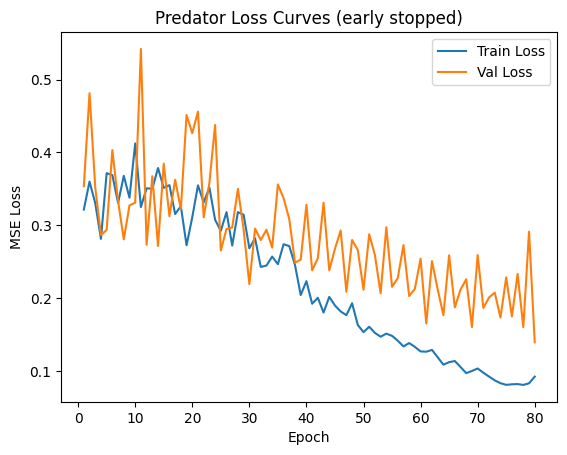

In [6]:
pred_policy = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=128, prey_bs=2048, epochs=150, lr=1e-3, device='cpu', early_stopping=True, patience=50)
torch.save(pred_policy, os.path.join(path, "bc_pred_policy.pt"))

[PREY] Epoch 01  Train Loss: 0.444801  Val Loss: 0.477927
[PREY] Epoch 02  Train Loss: 0.421351  Val Loss: 0.434539
[PREY] Epoch 03  Train Loss: 0.413275  Val Loss: 0.442495
[PREY] Epoch 04  Train Loss: 0.424933  Val Loss: 0.440527
[PREY] Epoch 05  Train Loss: 0.423662  Val Loss: 0.466891
[PREY] Epoch 06  Train Loss: 0.427657  Val Loss: 0.405860
[PREY] Epoch 07  Train Loss: 0.422932  Val Loss: 0.450169
[PREY] Epoch 08  Train Loss: 0.411096  Val Loss: 0.423856
[PREY] Epoch 09  Train Loss: 0.420124  Val Loss: 0.423757
[PREY] Epoch 10  Train Loss: 0.409742  Val Loss: 0.434855
[PREY] Epoch 11  Train Loss: 0.400634  Val Loss: 0.440991
[PREY] Epoch 12  Train Loss: 0.402216  Val Loss: 0.416921
[PREY] Epoch 13  Train Loss: 0.405659  Val Loss: 0.405640
[PREY] Epoch 14  Train Loss: 0.396239  Val Loss: 0.405147
[PREY] Epoch 15  Train Loss: 0.400020  Val Loss: 0.405444
[PREY] Epoch 16  Train Loss: 0.390811  Val Loss: 0.393366
[PREY] Epoch 17  Train Loss: 0.379796  Val Loss: 0.379704
[PREY] Epoch 1

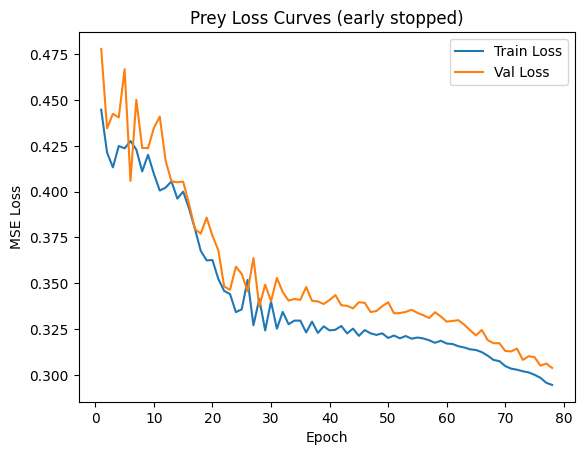

In [7]:
prey_policy = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=128, prey_bs=2048, epochs=250, lr=1e-3, device='cpu', early_stopping=True, patience=50)
torch.save(prey_policy, os.path.join(path, "bc_prey_policy.pt"))

In [8]:
# Expert Data
total_detections=33
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}"

start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [9]:
import math
import torch

def continuous_to_discrete2(actions, action_count, role="predator"):
    """
    actions: Tensor mit Winkeln θ in Radiant, in [-π, π]
             (0 = rechts, π/2 = oben, -π/2 = unten, π = links)
    """

    theta = actions

    # 1) θ (rad) -> θ in Grad
    theta_deg = theta * 180 / math.pi # scale to polar coordinates

    # 2) Couzin-θ -> Aquarium-γ
    #    0° (Couzin, rechts)   -> 90° (Aquarium, rechts)
    #    90° (Couzin, oben)    -> 0°  (Aquarium, oben)
    #   -90° (Couzin, unten)   -> 180°(Aquarium, unten)
    #   180° (Couzin, links)   -> 270°(Aquarium, links)
    gamma = 90.0 - theta_deg

    # 3) auf [0, 360) wrappen
    gamma = torch.remainder(gamma, 360.0)

    # 4) in diskrete Action umrechnen
    a_float = gamma / 360.0 * action_count
    a_round = torch.round(a_float)
    discrete_action = torch.remainder(a_round, action_count).long()

    if role == "predator":
        return discrete_action.item()
    else:
        return discrete_action.flatten().tolist()


In [10]:
def run_policies2(env, pred_policy, prey_policy, prey_features=4): 
    print("Press 'q' to end simulation.")

    metrics = []
    pred_actions= []
    pred_mu = []
    pred_sigma = []

    prey_actions= []

    while True:
        if keyboard.is_pressed('q'):
            break

        global_state = env.state().item()
        pred_tensor, prey_tensor, xs, ys, dx, dy, vxs, vys = get_eval_features(global_state)

        pred_states = pred_tensor[..., :4]
        actions, mu, sigma, weights = pred_policy.forward_pred(pred_states)
        dis_pred = continuous_to_discrete2(actions, 360, role='predator')
        pred_actions.append(dis_pred)
        pred_mu.append(mu.detach().cpu().numpy())
        pred_sigma.append(sigma.detach().cpu().numpy())

        prey_states = prey_tensor[..., :4]
        actions, mu, sigma, weights = prey_policy.forward_prey(prey_states)
        dis_prey = continuous_to_discrete2(actions, 360, role='prey')
        prey_actions.append(dis_prey)

        action_dict = {}
        for agent in env.agents:
            if agent.startswith("prey"):
                idx = int(agent.split("_")[1])
                action_dict[agent] = dis_prey[idx]
            elif agent == "predator_0":
                action_dict[agent] = dis_pred

        env.step(action_dict)

        metrics.append({"polarization": compute_polarization(vxs, vys),
                        "angular_momentum": compute_angular_momentum(xs, ys, vxs, vys),
                        "xs": xs,
                        "ys": ys,
                        "dx": dx,
                        "dy": dy,
                        "vxs": vxs,
                        "vys": vys})
        
        env.render()

    try:
        env.close()
    except:
        pass

    return metrics, pred_actions, prey_actions, pred_mu, pred_sigma

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_dir = rf'..\models\trained_policies'

pred_policy = torch.load(os.path.join(policy_dir, "bc_pred_policy.pt"), weights_only=False)
prey_policy = torch.load(os.path.join(policy_dir, "bc_prey_policy.pt"), weights_only=False)

In [17]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=False)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics, pred_actions, prey_actions, pred_mu, pred_sigma = run_policies2(env, pred_policy, prey_policy, prey_features=4)

Press 'q' to end simulation.
[DEBUG] Prey prey_0 action=86
[DEBUG] Prey prey_1 action=83
[DEBUG] Prey prey_2 action=84
[DEBUG] Prey prey_3 action=81
[DEBUG] Prey prey_4 action=84
[DEBUG] Prey prey_5 action=83
[DEBUG] Prey prey_6 action=83
[DEBUG] Prey prey_7 action=85
[DEBUG] Prey prey_8 action=81
[DEBUG] Prey prey_9 action=83
[DEBUG] Prey prey_10 action=84
[DEBUG] Prey prey_11 action=85
[DEBUG] Prey prey_12 action=87
[DEBUG] Prey prey_13 action=85
[DEBUG] Prey prey_14 action=85
[DEBUG] Prey prey_15 action=84
[DEBUG] Prey prey_16 action=84
[DEBUG] Prey prey_17 action=84
[DEBUG] Prey prey_18 action=84
[DEBUG] Prey prey_19 action=85
[DEBUG] Prey prey_20 action=85
[DEBUG] Prey prey_21 action=84
[DEBUG] Prey prey_22 action=85
[DEBUG] Prey prey_23 action=76
[DEBUG] Prey prey_24 action=80
[DEBUG] Prey prey_25 action=83
[DEBUG] Prey prey_26 action=86
[DEBUG] Prey prey_27 action=81
[DEBUG] Prey prey_28 action=86
[DEBUG] Prey prey_29 action=86
[DEBUG] Prey prey_30 action=85
[DEBUG] Prey prey_31

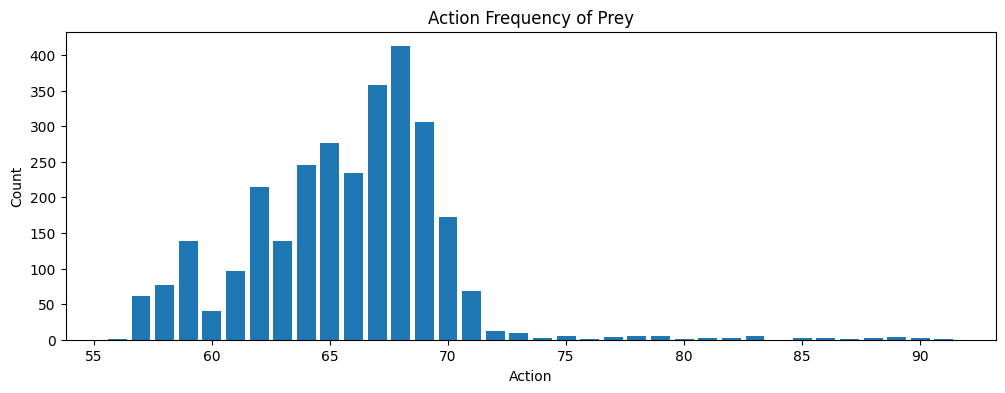

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

# prey_actions verschachtelt → flachen
flat_actions = [a for sub in prey_actions for a in sub]

# Häufigkeiten zählen
counts = Counter(flat_actions)

# x = Actions, y = Häufigkeit
x = list(counts.keys())
y = list(counts.values())

plt.figure(figsize=(12, 4))
plt.bar(x, y)
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Frequency of Prey")
plt.show()

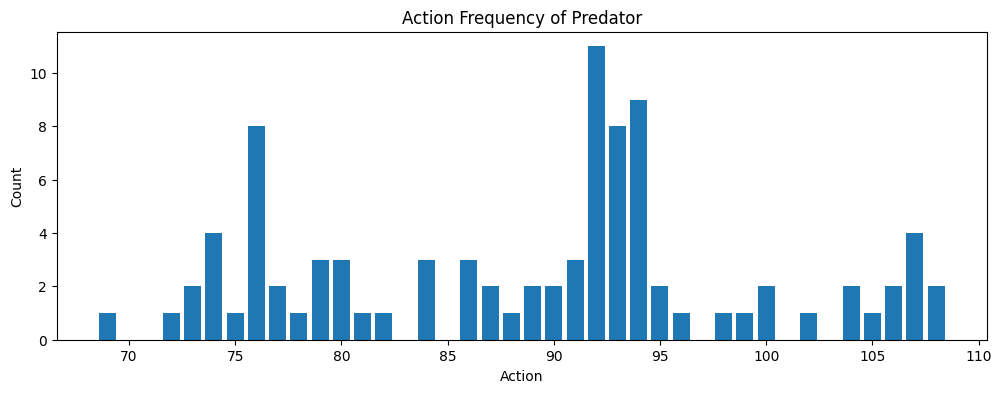

In [14]:
# Häufigkeiten zählen
counts = Counter(pred_actions)

# x = Actions, y = Häufigkeit
x = list(counts.keys())
y = list(counts.values())

plt.figure(figsize=(12, 4))
plt.bar(x, y)
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Frequency of Predator")
plt.show()

In [15]:
'''# Häufigkeiten zählen
flat_list = np.concatenate(pred_mu).flatten().tolist()
counts = Counter(flat_list)

# x = Actions, y = Häufigkeit
x = list(counts.keys())
y = list(counts.values())

plt.figure(figsize=(12, 4))
plt.bar(x, y)
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Frequency of Predator")
plt.show()'''

'# Häufigkeiten zählen\nflat_list = np.concatenate(pred_mu).flatten().tolist()\ncounts = Counter(flat_list)\n\n# x = Actions, y = Häufigkeit\nx = list(counts.keys())\ny = list(counts.values())\n\nplt.figure(figsize=(12, 4))\nplt.bar(x, y)\nplt.xlabel("Action")\nplt.ylabel("Count")\nplt.title("Action Frequency of Predator")\nplt.show()'

In [16]:
'''# Häufigkeiten zählen
flat_list = np.concatenate(pred_sigma).flatten().tolist()
counts = Counter(flat_list)

# x = Actions, y = Häufigkeit
x = list(counts.keys())
y = list(counts.values())

plt.figure(figsize=(12, 4))
plt.bar(x, y)
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Frequency of Predator")
plt.show()'''

'# Häufigkeiten zählen\nflat_list = np.concatenate(pred_sigma).flatten().tolist()\ncounts = Counter(flat_list)\n\n# x = Actions, y = Häufigkeit\nx = list(counts.keys())\ny = list(counts.values())\n\nplt.figure(figsize=(12, 4))\nplt.bar(x, y)\nplt.xlabel("Action")\nplt.ylabel("Count")\nplt.title("Action Frequency of Predator")\nplt.show()'